## A/B–тестирование
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Выгрузка данных с Яндекс.Диска

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlencode

In [2]:
# Базовый URL для публичного API Яндекс.Диска, который используется для получения ссылки на скачивание файла
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Функция для загрузки данных из CSV-файла, расположенного по публичной ссылке на Яндекс.Диске
def upload_df(link, sep=','):
    url = base_url + urlencode(dict(public_key=link)) # Формирование полного URL запроса, добавляя публичный ключ в параметры запроса
    response = requests.get(url) # Выполнение GET-запрос к сформированному URL для получения информации о файле
    download_link = response.json()['href']  # Извлечение ссылки для скачивания файла из ответа, который вернул API Яндекс.Диска
    return pd.read_csv(download_link, sep=sep) # Чтение CSV-файла по ссылке для скачивания и возвращение его в виде DataFrame

In [3]:
groups = upload_df('https://disk.yandex.ru/d/cM6g26ucVBlc-A', ';')
checks = upload_df('https://disk.yandex.ru/d/pld_TzJ-N80cHw', ';')
active_studs = upload_df('https://disk.yandex.ru/d/YFwfeE_HjcWM8g')

### Информация о предоставленных данных
Предоставлено 4 файла с информацией о пользователях(их принадлежности к группе), активности в дни проведения эксперимента и стоимости оплаты услуг на сайте.

In [4]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


Файл с информацией о принадлежности пользователя к контрольной или целевой группе 

In [5]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


В файле нет пропущенных значений.

In [6]:
groups.duplicated().sum()

0

В файле не обнаружены дубликаты.

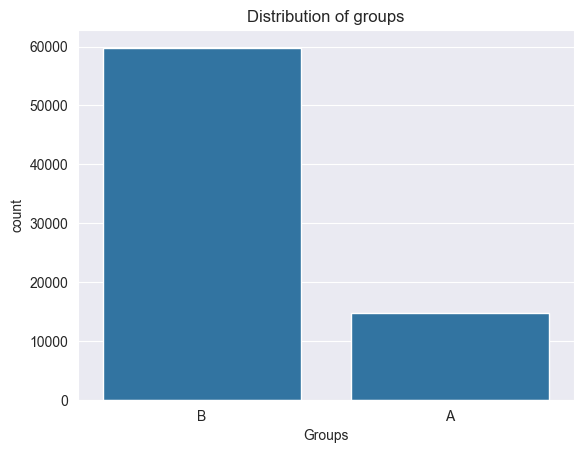

In [7]:
sns.barplot(data=groups['grp'].value_counts())
plt.title('Distribution of groups')
plt.xlabel('Groups')
plt.show()

Распределение количества пользователей по группам. Целевая группа(группа B) преобладает по количеству пользователей.

In [8]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


Файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [9]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [10]:
checks.duplicated().sum()

0

В файле с информацией об оплатах пользователей не обнаружены дубликаты и пропущенные значения.

In [11]:
checks.rename(columns={'student_id': 'id'}, inplace=True) # Переименование столбца "student_id" на "id"

In [12]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


Файл с информацией об активности пользователей. Пользователь считается активным, если зашел на платформу в дни проведения эксперимента.

In [13]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [14]:
active_studs.duplicated().sum()

0

В файле с информацией об активных пользователях не обнаружены дубликаты и пропущенные значения.

In [15]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True) # Переименование столбца "student_id" на "id"

### Объединение таблиц и создание новых признаков

In [84]:
data = groups.merge(checks, on='id', how='left') # Присоединение таблицы об оплатах к таблице с группами пользователей

In [85]:
data

,id,grp,rev
0,1489,B,NaN
1,1627,A,990.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74479,5692459,B,NaN
74480,5692572,B,NaN
74481,5692865,B,NaN
74482,5693667,B,NaN


In [87]:
data.fillna(-1, inplace=True) # Заполнение пропусков в признаке с суммой оплаты

In [88]:
data['is_paid'] = data['rev'].apply(lambda x: 1 if x > 0 else 0) # Добавление нового признака о факте оплаты

In [89]:
data['is_active'] = data['id'].isin(active_studs['id']).apply(lambda x: 1 if x else 0) # Добавление нового признака об активности пользователя в дни проведения эксперимента

In [90]:
data.isna().sum()

id           0
grp          0
rev          0
is_paid      0
is_active    0
dtype: int64

In [91]:
data.duplicated().sum()

0

После присоединения таблиц в данных не обнаружено пропусков и дубликатов.

In [92]:
data

,id,grp,rev,is_paid,is_active
0,1489,B,-1.0,0,0
1,1627,A,990.0,1,1
2,1768,B,-1.0,0,0
3,1783,B,-1.0,0,0
4,1794,A,-1.0,0,0
...,...,...,...,...,...
74479,5692459,B,-1.0,0,0
74480,5692572,B,-1.0,0,0
74481,5692865,B,-1.0,0,0
74482,5693667,B,-1.0,0,0


Итоговая таблица.

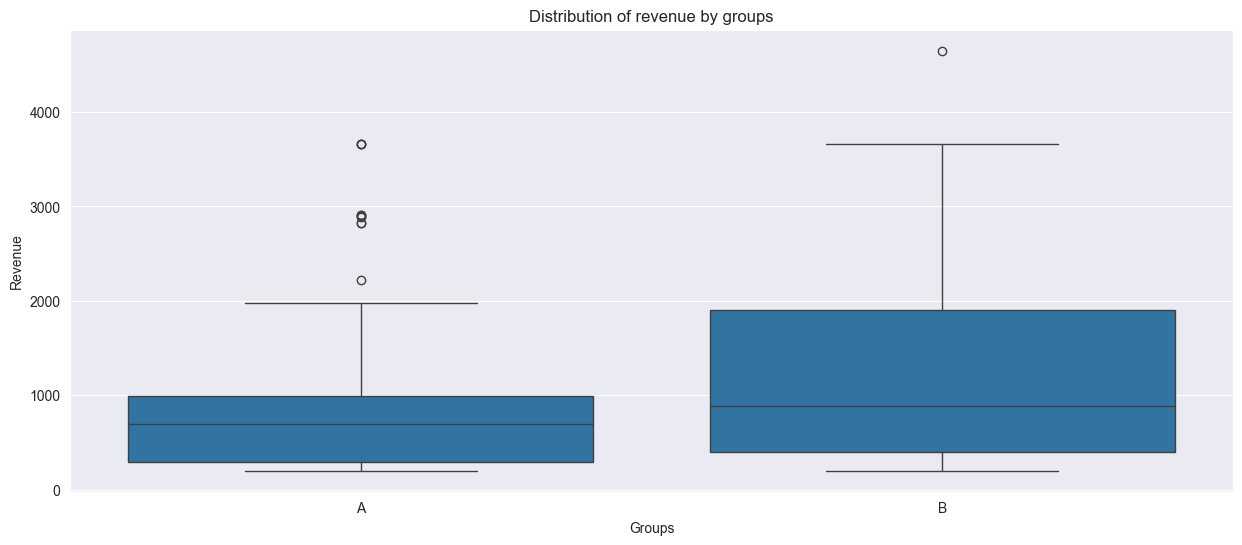

In [24]:
fig = plt.figure(figsize=(15, 6))
sns.boxplot(data.query('rev>0'), y='rev', x='grp') # Распределение дохода больше нуля
plt.title('Distribution of revenue by groups')
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.show()

Данные в обеих группах не соответствуют нормальному распределению и содержат выбросы, причем в контрольной группе(группа A) выбросов больше. Также наблюдаются различия в медианах и квартилях между группами, которые могут указывать на неодинаковое распределение значений и различия в поведении пользователей или эффектах внедрённых изменений.

### Разделение данных на тестовую и контрольную выборки

In [25]:
control = data[data['grp'] == 'A'] # Контрольная группа
test = data[data['grp'] == 'B'] # Тестовая группа

In [26]:
control[control['is_paid'] == 1]['rev'].describe()

count     107.000000
mean      860.710280
std       815.893445
min       199.000000
25%       290.000000
50%       690.000000
75%       990.000000
max      3660.000000
Name: rev, dtype: float64

In [27]:
test[test['is_paid'] == 1]['rev'].describe()

count     433.000000
mean     1106.997699
std       741.714026
min       199.000000
25%       398.000000
50%       880.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

Среднее значение, медиана и стандартное отклонение в целевой группе отличаются от контрольной группы, что также указывает на различия в распределении данных и возможное влияние применённых изменений.

### Расчет метрик, построение графиков по полученным показателям

##### CR - Конверсия активных пользователей в оплату по группам.

In [28]:
# Функция, в которой реализована метрика конверсии активных пользователей в оплату
def CR(data):
    target_action = data.query('is_active==1')['is_paid'].sum() # Количество пользователей, совершивших целевое действие
    cr = target_action / len(data.query('is_active==1')) # Конверсия в оплату
    return cr * 100

In [97]:
cr_control = CR(control) # Конверсия контрольной группы
cr_test = CR(test) # Конверсия тестовой группы

print(f'CR Контрольная группа: {cr_control:.2f}%')
print(f'CR Целевая группа: {cr_test:.2f}%')

CR Контрольная группа: 5.08%
CR Целевая группа: 4.61%


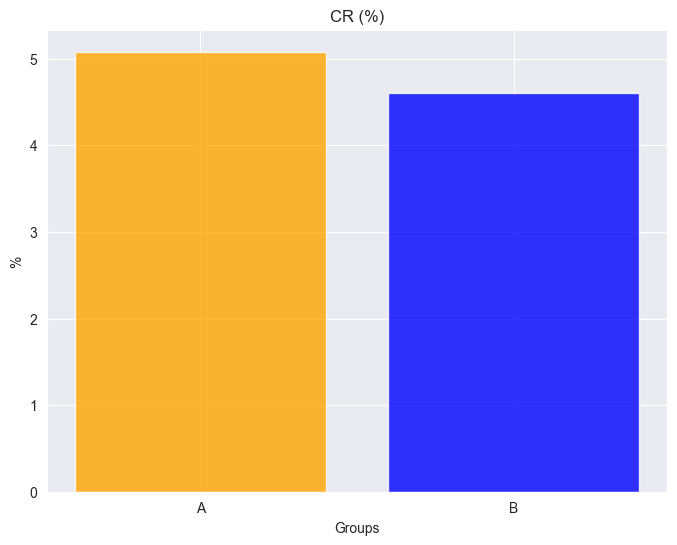

In [30]:
values = [cr_control, cr_test]
labels = ['A', 'B']

# Построение barplot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['orange', 'blue'], alpha=0.8)
plt.title('CR (%)')
plt.xlabel('Groups')
plt.ylabel('%')
plt.show()

Рассмотрена конверсия, так как необходимо понять, изменила ли новая механика оплаты поведение пользователей, стали ли они чаще покупать. В данном случае, контрольная группа(группа А) демонстрирует более высокую конверсию в оплату по сравнению с пользователями, использующими новую механику оплаты. 

Это может указывать на наличие проблем в новой механике: возможные сбои, препятствующие оплате (например, не все карты проходят), неудобства для пользователей/неочевидность действий в алгоритме оплаты или снижение скорости работы сайта с внедрением новой механики оплаты.

##### ARPPU - Средний доход на платящего пользователя.

In [31]:
# Функция, в которой реализована метрика среднего дохода на платящего пользователя
def arppu(purchases):
    repeat_purchase = len(purchases) / purchases['id'].nunique() # Повторные покупки
    avg_rev = sum(purchases['rev']) / len(purchases) # Средний чек
    arppu = repeat_purchase * avg_rev # Средний доход на платящего пользователя
    return arppu

In [98]:
purchases_control = control.query('is_paid == 1') # Отделение пользователей, которые совершили оплату (контрольная группа)
purchases_test = test.query('is_paid == 1') # Отделение пользователей, которые совершили оплату (тестовая группа)

arppu_control = arppu(purchases_control) # ARPPU контрольная группа
arppu_test = arppu(purchases_test) # ARPPU тестовая группа

print(f'ARPPU (у.е) Контрольная группа: {arppu_control:.2f}')
print(f'ARPPU (у.е) Целевая группа: {arppu_test:.2f}')

ARPPU (у.е) Контрольная группа: 860.71
ARPPU (у.е) Целевая группа: 1107.00


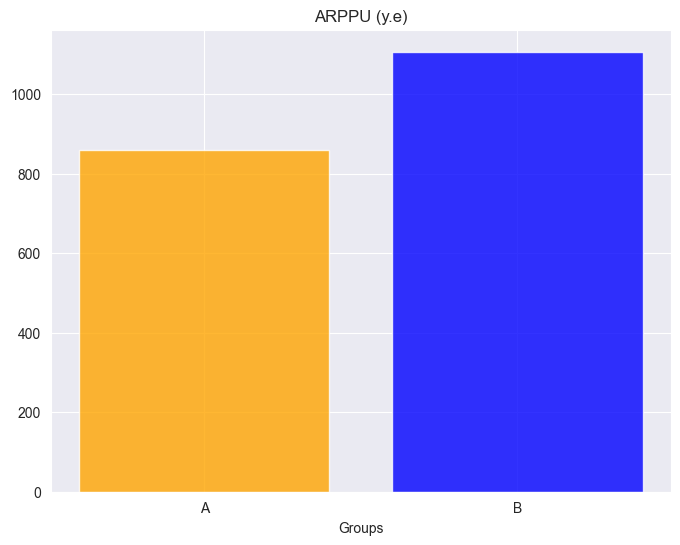

In [33]:
values = [arppu_control, arppu_test]
labels = ['A', 'B']

# Построение barplot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['orange', 'blue'], alpha=0.8)
plt.title('ARPPU (у.е)')
plt.xlabel('Groups')
plt.show()

Анализ новой механики оплаты также рассмотрен с точки зрения увеличения среднего чека пользователей, благодаря внедрению изменений в механике оплаты. Поэтому была выбрана метрика среднего дохода на платящего пользователя (ARPPU). В данном случае наблюдается рост этого показателя: целевая группа демонстрирует более высокий средний доход на платящего пользователя. 

Это может свидетельствовать о том, что изменение механики оплаты способствует увеличению суммы покупок, повышению эффективности ценообразования или изменению пользовательского поведения - возможно, изменения в механике оплаты изменили покупательские привычки пользователей, побуждая их совершать более крупные покупки или добавлять дополнительные товары и услуги, что увеличивает средний чек.

##### ARPU - средний доход на привлеченного пользователя.

In [64]:
arpu_control = arppu_control * cr_control # ARPU контрольная группа
arpu_test = arppu_test * cr_test # ARPU тестовая группа

print(f'ARPU (у.е) Контрольная группа: {arpu_control}')
print(f'ARPU (у.е) Целевая группа: {arpu_test}')

ARPU (у.е) Контрольная группа: 4373.641815580383
ARPU (у.е) Целевая группа: 5100.696006750601


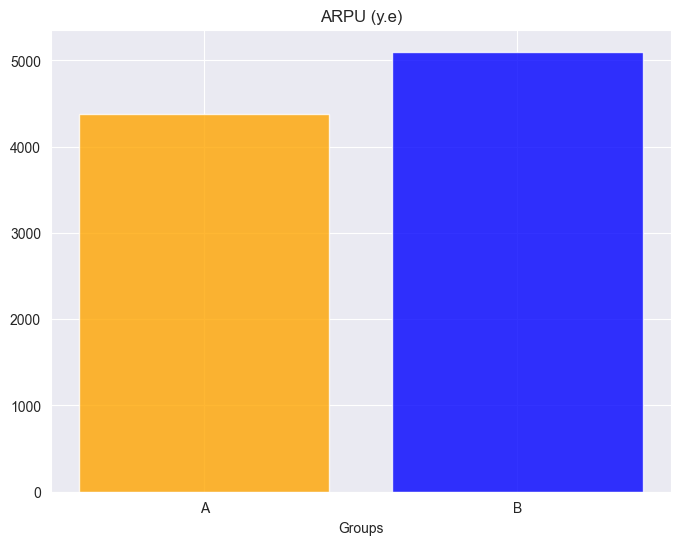

In [35]:
values = [arpu_control, arpu_test]
labels = ['A', 'B']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['orange', 'blue'], alpha=0.8)
plt.title('ARPU (у.е)')
plt.xlabel('Groups')
plt.show()

Новая механика оплаты может повлиять на общий доход от всех пользователей, независимо от того, совершают ли они платёжные транзакции или нет, поэтому рассматривается средний доход на пользователя (ARPU). 
В результате наблюдается рост среднего дохода на пользователя в целевой группе.

Это говорит о том, что новая механика оплаты может оказывать положительное влияние на финансовые показатели, даже несмотря на более низкую конверсию по сравнению с контрольной группой. Такое повышение ARPU указывает на то, что новая механика, возможно, привлекает пользователей, готовых тратить больше, или улучшает их средний расход, что может компенсировать снижение конверсии и в конечном итоге способствовать общему росту дохода.

In [36]:
data

,id,grp,rev,is_paid,is_active
0,1489,B,-1.0,0,0
1,1627,A,990.0,1,1
2,1768,B,-1.0,0,0
3,1783,B,-1.0,0,0
4,1794,A,-1.0,0,0
...,...,...,...,...,...
74479,5692459,B,-1.0,0,0
74480,5692572,B,-1.0,0,0
74481,5692865,B,-1.0,0,0
74482,5693667,B,-1.0,0,0


##### Доля пользователей, которые оплатили, но не были активны в течение указанного периода.

In [37]:
paid_not_active = data.query('is_active == 0 and is_paid == 1').groupby('grp')['id'].count() / data.groupby('grp')['id'].count()
paid_not_active

grp
A    0.001977
B    0.002006
Name: id, dtype: float64

Данная метрика рассматривается, чтобы оценить, влияет ли новая механика оплаты на общую удовлетворенность и активность пользователей. Высокая доля пользователей, которые оплатили, но не были активны, может указывать на проблемы с вовлечением или интересом к продукту после оплаты. В данном случае процент в обеих группах небольшой, однако
в целевой группе эта доля немного выше, чем в контрольной. 

Возможно, новая механика оплаты привлекает пользователей, которые, несмотря на платежеспособность, не слишком активно используют продукт. 

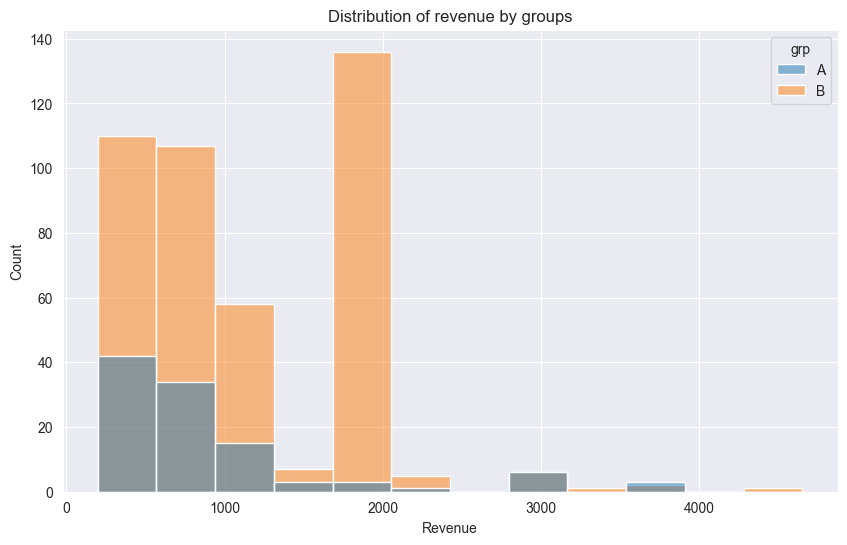

In [38]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data.query('rev>0'), x='rev', hue='grp')
plt.title('Distribution of revenue by groups')
plt.xlabel('Revenue')
plt.show()

В обеих группах распределение данных не соответствует нормальному закону. Тем не менее, в целевой группе наблюдается рост покупательской способности, несмотря на более низкую конверсию по сравнению с контрольной группой. 

Рост в покупательской способности может указывать на то, что новая механика оплаты привлекает пользователей, которые готовы тратить больше, хотя и снижает общую конверсию. Важно провести статистические тесты, чтобы подтвердить, насколько эти изменения значимы и не являются ли они следствием случайных колебаний.

### Проведение статистических тестов

**Нулевая гипотеза (H0):** Конверсии в двух группах статистически не различаются. 

**Альтернативная гипотеза (H1):** Конверсии в двух группах статистически различаются.

In [39]:
from scipy.stats import chi2_contingency, chi2

In [40]:
payments = data.groupby(['grp', 'is_paid'])['rev'].count().reset_index() # Создание датафрейма, в котором хранится число пользователей и статус оплаты
payments = payments.pivot(index='grp', columns='is_paid', values='rev')

In [41]:
payments

is_paid,0,1
grp,,
A,14564,107
B,59380,433


##### Тест Хи-квадрат

In [42]:
stat, p_value, dof, expected = chi2_contingency(payments)
print(f"Хи-квадрат: {stat}\np-value: {p_value}\nКоличество степеней свободы: {dof}")

Хи-квадрат: 0.00022142268710807016
p-value: 0.9881276936892961
Количество степеней свободы: 1


Тест Хи-квадрат был выбран для оценки независимости между конверсиями в двух группах, так как он подходит для анализа категориальных данных

In [43]:
prob = .95 # Уровень значимости (вероятность для критического значения)
critical = chi2.ppf(prob, dof) # Критическое значение для теста с заданным уровнем значимости и степенями свободы
if abs(stat) >= critical:
    print(f'Отклоняем H0: конверсии двух групп статистически различаются, p-value: {p_value:.2f}')
else:
    print(f'Не отклоняем H0: конверсии двух групп статистически не различаются, p-value: {p_value:.2f}')

Не отклоняем H0: конверсии двух групп статистически не различаются, p-value: 0.99


P-value значительно выше уровня значимости 0.05, это означает, что нулевая гипотеза не отклоняется. Таким образом, статистически значимых различий в конверсиях между двумя группами нет.

**Нулевая гипотеза (H0):** Средние значения доходов в контрольной и целевой группах статистически не различаются

**Альтернативная гипотеза (H1):** Средние значения доходов в контрольной и целевой группах статистически различны

In [44]:
from scipy.stats import mannwhitneyu, ttest_ind, norm
from tqdm.auto import tqdm
import numpy as np

In [45]:
control_rev = purchases_control['rev'] # Контрольная выборка с платящими пользователями
test_rev = purchases_test['rev'] # Тестовая выборка с платящими пользователями

In [46]:
# Функция, в которой реализована проверка на статистическую значимость с уровнем значимости 5%
def stat_significance(p_value):
    alpha = .05 # Уровень значимости, который используется для принятия решения
    
    # Проверка, меньше ли p-value установленного уровня значимости alpha
    if p_value <= alpha:
        print(f'Отклоняем H0: Средние значения доходов различаются, p-value: {p_value:.4f}')
    else:
        print(f'Не отклоняем H0: Средние значения доходов одинаковы, p-value: {p_value:.4f}')

Функция stat_significance используется для принятия решения о статистической значимости результатов теста на основе сравнения p-value с заранее установленным уровнем значимости (alpha = 0.05). В зависимости от результата сравнения она выводит соответствующее сообщение.

##### Т-тест для независимых выборок

In [47]:
stat, p_value = ttest_ind(control_rev, test_rev) # t-тест для двух независимых выборок с положительными доходами
print(f"t-статистика: {stat}\np-value: {p_value}\n")
stat_significance(p_value)

t-статистика: -3.0139777685309754
p-value: 0.002699993302662584

Отклоняем H0: Средние значения доходов различаются, p-value: 0.0027


T-тест для независимых выборок был выбран, так как данные представляют собой сравнение средних значений между двумя группами. P-value значительно ниже уровня значимости 0.05, что позволяет отклонить нулевую гипотезу. Это указывает на статистически значимые различия в средних доходах между контрольной и целевой группами, что свидетельствует о влиянии новой механики оплаты на поведение пользователей и их склонность к совершению покупок.

##### U-критерий Манна-Уитни

In [99]:
stat, p_value = mannwhitneyu(control_rev, test_rev)
print(f"U-критерий Манна-Уитни: {stat}\np-value: {p_value}\n")
stat_significance(p_value)

U-критерий Манна-Уитни: 17850.0
p-value: 0.00021019690333618245

Отклоняем H0: Средние значения доходов различаются, p-value: 0.0002


U-критерий Манна-Уитни был выбран, так как данные могли не следовать нормальному распределению, и предварительно распределение выборочных средних для применения t-теста не было проверено. Низкое значение p-value по сравнению с уровнем значимости 0.05 позволяет отвергнуть нулевую гипотезу, что подтверждает наличие статистически значимых различий в средних значениях доходов между контрольной и целевой группами.

**Бутстрап-тест**

In [49]:
# Начальное значение генератора случайных чисел для воспроизводимости результатов
np.random.seed(12)

# Функция, в которой реализован бутстрап-тест
def get_bootstrap(data_column_1, data_column_2, iterations=15000, statistic=np.mean, sign_level=0.05):
    # Определение длины бутстрап-выборок
    boot_len = max(len(data_column_1), len(data_column_2))
    
    # Инициализация списков для хранения результатов бутстрап-выборок
    boot_data, samples_1_a, samples_2_a = [], [], []

    # Бутстрап-сэмплирование
    for _ in tqdm(range(iterations)):
        # Бутстрап-выборки для каждой группы
        sample_1 = data_column_1.sample(boot_len, replace=True).values
        sample_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(sample_2 - sample_1)) # Вычисление статистики для разности между выборками
        
        samples_1_a.append(np.mean(sample_1)) # Добавляем среднего значения выборок в список
        samples_2_a.append(np.mean(sample_2)) # Добавляем среднего значения выборок в список

    quants = pd.DataFrame(boot_data).quantile([sign_level / 2, 1 - sign_level / 2]) # Вычисление квантильного значения для интервала значимости

    # Вычисление p-значения
    boot_mean, boot_std = np.mean(boot_data), np.std(boot_data)
    p_1 = norm.cdf(0, boot_mean, boot_std)   # p-значение для положительного среднего
    p_2 = norm.cdf(0, -boot_mean, boot_std)  # p-значение для отрицательного среднего
    p_value = min(p_1, p_2) * 2              # Двустороннее p-значение

    # Построение графиков
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
    
    # График 1: распределение разностей статистик
    axes[0].grid(True, linestyle='-', linewidth=0.7, color='lightgrey')
    axes[0].set_facecolor('white')
    n, _, bars = axes[0].hist(boot_data, bins=50)
    
    # Окрашивание столбцов в зависимости от квантилей
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('palevioletred')
        else: 
            bar.set_facecolor('deepskyblue')
        bar.set_edgecolor('purple')

    # Вертикальные линии для среднего и квантилей
    axes[0].vlines(boot_mean, ymin=0, ymax=max(n), linestyle='-', color='purple', linewidth=0.7)
    axes[0].vlines(quants, ymin=0, ymax=max(n), linestyle='--', color='purple', linewidth=0.7)
    axes[0].annotate(f"{quants.iloc[0][0]:.3f}", xy=(quants.iloc[0][0], 0), xytext=(quants.iloc[0][0] + .001, max(n) / 2))
    axes[0].annotate(f"{quants.iloc[1][0]:.3f}", xy=(quants.iloc[1][0], 0), xytext=(quants.iloc[1][0] + .001, max(n) / 2))
    axes[0].set(xlabel='boot_data', ylabel='Frequency', title=f'Distribution of differences in {statistic.__name__}s')
    
    # График 2: распределение средних значений бутстрап-выборок
    axes[1].grid(True, linestyle='-', linewidth=0.7, color='lightgrey')
    axes[1].set_facecolor('white')
    axes[1].hist(samples_1_a, bins=50, color='deepskyblue', alpha=0.5, label=f"{statistic.__name__}s of boot dataset 1")
    axes[1].hist(samples_2_a, bins=50, color='crimson', alpha=0.5, label=f"{statistic.__name__}s of boot dataset 2")
    axes[1].set(ylabel='Frequency')
    axes[1].legend()
    plt.subplots_adjust(hspace=0.2)

    # Вывод результата
    conclusion = "reject" if p_value <= sign_level else "fail to reject"
    print(f"The p-value of {np.round(p_value, 6)} suggests that there is evidence to {conclusion} the null hypothesis at the {sign_level} significance level.")

    return {'quants': quants, 'boot mean': boot_mean, 'p_value': p_value}

Функция, в которой реализован бутстрап-тест.

  0%|          | 0/15000 [00:00<?, ?it/s]

The p-value of 0.000837 suggests that there is evidence to reject the null hypothesis at the 0.05 significance level.


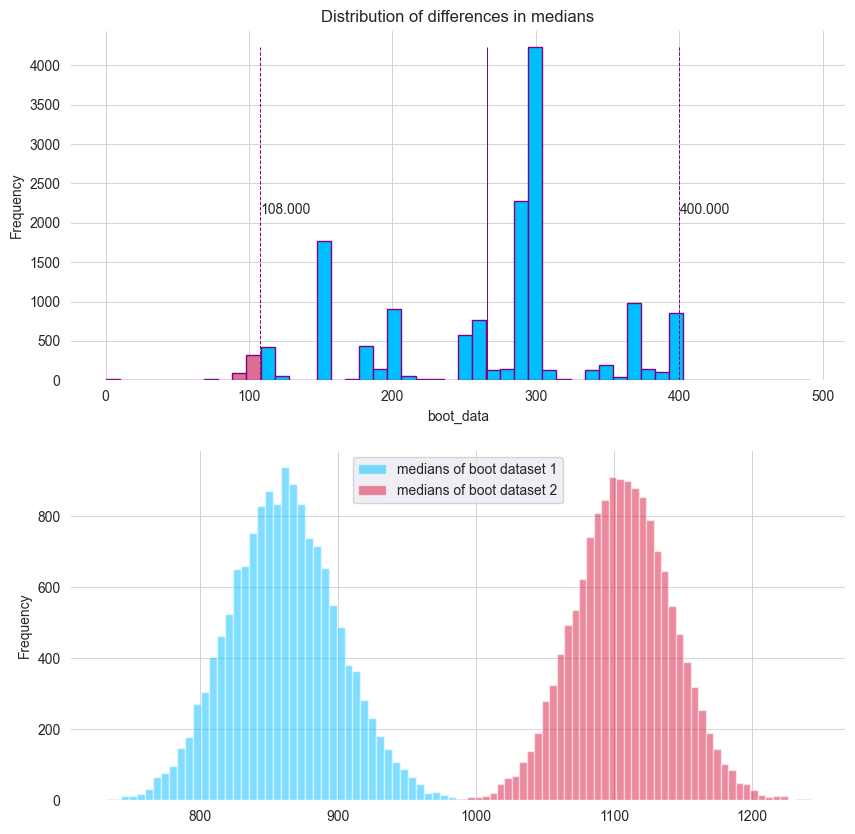

In [50]:
boot_data = get_bootstrap(control_rev, test_rev,statistic=np.median) 
p_value = boot_data['p_value']

In [83]:
p_value = boot_data['p_value']
print(f"boot mean: {boot_data['boot mean']}") # Значение представляет среднюю разницу между выборками, полученную в результате бутстрап-сэмплирования.
print(f"quants: {boot_data['quants']}\n") # Значения формируют 95%-ный доверительный интервал для разности медиан между двумя выборками
stat_significance(p_value)

boot mean: 266.1676683266667
quants:            0
0.025  108.0
0.975  400.0

Отклоняем H0: Средние значения доходов различаются, p-value: 0.0008


В качестве статистики бутстрапа была выбрана медиана (робастная оценка), учитывая наличие выбросов в оплатах обеих групп и неравномерном распределении данных. 
Бутсрап-тест выбран как непараметрический метод, который не требует предположений о распределении данных и помогает улучшить точность оценок медианы через многократный ресэмплинг исходных данных. 

Поскольку доверительный интервал не включает ноль (все значения положительные), это указывает на статистически значимое различие между выборками. 
Значительно низкий p-value по сравнению с уровнем значимости 0.05 подтверждает статистически значимые различия в средних доходах между контрольной и целевой группами.

# Вывод
В ходе анализа новой механики оплаты на сайте, было проведено сравнение ключевых метрик между контрольной и целевой группами, а так же проведение статистических тестов для выявления влияния новой механики оплаты на пользовательский опыт. Вот основные выводы:

#### Метрики и их анализ:
**CR (Конверсия):** В целевой группе конверсия оказалась ниже по сравнению с контрольной группой. Это может указывать на потенциальные проблемы с новой механикой оплаты, такие как технические сбои, снижение удобства для пользователей или недостаточную ясность в её внедрении.

**ARPPU (Средний доход на платящего пользователя):** В целевой группе наблюдается рост показателя ARPPU, что свидетельствует о том, что платящие пользователи в новой механике тратят больше. Это может указывать на положительное влияние новой механики на средний чек.

**ARPU (Средний доход на пользователя):** Этот показатель также вырос в целевой группе, подтверждая, что новая механика оплаты способствует увеличению общего дохода, несмотря на снижение конверсии.

**Доля пользователей, которые оплатили, но не были активны в течение указанного периода:** Этот показатель оказался схожим в обеих группах, что указывает на отсутствие значительных изменений в поведении пользователей, которые оплатили, но не проявили активности.
##
#### Статистическая значимость различий:
**T-тест** и **U-критерий Манна-Уитни** подтвердили статистически значимые различия в средних доходах между группами, что указывает на наличие эффекта новой механики оплаты.

**Бутсрап-тест** также подтвердил результаты других тестов, продемонстрировав, что различия в доходах статистически значимы.

**Тест Хи-квадрат** для конверсий показал, что различия в конверсии между группами не являются статистически значимыми, что указывает на отсутствие значимых изменений в поведении пользователей по этому показателю.
#
Таким образом, новая механика оплаты демонстрирует увеличение доходов без значительного влияния на конверсию, что подтверждает её перспективность для внедрения.

### Вычисление метрик с учетом дополнительного файла с пользоватеями

In [52]:
group_add = upload_df('https://disk.yandex.ru/d/1-7bzX5vd7bRQQ')

Дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных

In [77]:
len(group_add)

92

Для оценки результатов A/B-теста было добавлено 92 новых пользователя, распределённых по группам.

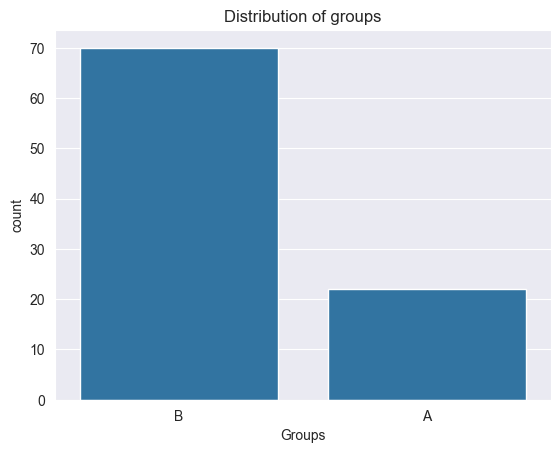

In [53]:
sns.barplot(group_add['grp'].value_counts())
plt.title('Distribution of groups')
plt.xlabel('Groups')
plt.show()

Распределение количества пользователей по группам дополнительного файла с пользователями. Целевая группа (группа В) также преобладает по количеству пользователей.

In [104]:
def build(data, add):
    # Добавление к существующей таблице data дополнительного файла с пользователями и заполнение пропущенных значений
    data = pd.concat([data, add], ignore_index=True)
    data['rev'] = data['rev'].fillna(value=-1) #
    data['is_paid'] = data['rev'].apply(lambda x: 1 if x > 0 else 0) 
    data['is_active'] = data['id'].isin(active_studs['id']).apply(lambda x: 1 if x else 0) 
    
    # Разделение данных на контрольную и тестовую выборку
    control = data[data['grp'] == 'A'] 
    test = data[data['grp'] == 'B'] 
    
    # Пересчитывание метрик
    metrics = {'CR':[], 'ARPPU': [], 'ARPU': []} # Словарь, в котором будут храниться посчитанные метрики
    
    cr_control = CR(control) 
    cr_test = CR(test) 
    
    metrics['CR'].append(cr_control)
    metrics['CR'].append(cr_test)
    
    print(f'CR (%) Контрольная группа: {cr_control:.2f}%')
    print(f'CR (%) Целевая группа: {cr_test:.2f}%\n')

    purchases_control = control.query('is_paid == 1') # Отделяем только заплативших пользователей
    purchases_test = test.query('is_paid == 1') 
    
    arppu_control = arppu(purchases_control)
    arppu_test = arppu(purchases_test)
    
    metrics['ARPPU'].append(arppu_control)
    metrics['ARPPU'].append(arppu_test)
    
    print(f'ARPPU (у.е) Контрольная группа: {arppu_control:.2f}')
    print(f'ARPPU (у.е) Целевая группа: {arppu_test:.2f}\n')

    arpu_control = arppu_control * cr_control
    arpu_test = arppu_test * cr_test
    
    metrics['ARPU'].append(arpu_control)
    metrics['ARPU'].append(arpu_test)
    
    print(f'ARPU (у.е) Контрольная группа: {arpu_control:.2f}')
    print(f'ARPU (у.е) Целевая группа: {arpu_test:.2f}')
    
    return data, pd.DataFrame(metrics, columns=['CR', 'ARPPU', 'ARPU'], index=['A', 'B'])

Реализована функция, которая автоматически подгружает информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывает метрики.

In [105]:
data_nw, metrics_nw = build(data, group_add)

CR (%) Контрольная группа: 5.07%
CR (%) Целевая группа: 4.60%

ARPPU (у.е) Контрольная группа: 860.71
ARPPU (у.е) Целевая группа: 1107.00

ARPU (у.е) Контрольная группа: 4365.11
ARPU (у.е) Целевая группа: 5093.20


Спустя 2 дня после внедрения новой механики оплаты конверсия в обеих группах немного снизилась(5.07% по сравнению с 5.08% для контрольной группы и 4.61% по сравнению с 4.60% для целевой). Это снижение может быть вызвано временным влиянием новой механики или другими внешними факторами, такими как сезонные колебания, технические сбои или изменения в пользовательском поведении, например, адаптация к новой механике.

ARPPU в обеих группах осталось неизменным. Это может означать, что новые оплаты не происходили, либо изменения в количестве оплат компенсировались изменениями в средней сумме оплаты.

ARPU снизился в обеих группах примерно на 7-8 единиц(4373.6 по сравнению с 4365.1 для контрольной группы и 5100.7 по сравнению с 5093.2 для целевой). Это может указывать на сезонные изменения, такие как снижение интереса пользователей или уменьшение их активности в течение этих двух дней, что также повлияло на конверсию.

In [80]:
len(data_nw.query('is_paid == 1')) / len(data.query('is_paid == 1'))

1.0

In [82]:
len(data_nw) / len(data)

1.0012351645991084

С учётом дополнительного файла пользователей можно объяснить изменения метрик в обеих группах: новые пользователи не совершили оплат.

In [74]:
def plot_metric(metrics, title):
    figure, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    figure.suptitle(title, fontsize=14)
    ax_1 = sns.barplot(x=metrics.index, y=metrics['CR'], ax=ax[0], hue=metrics.index)
    ax_1.set_xlabel('Groups')
    ax_1.set_title('Метрика CR (%)')
    
    ax_2 = sns.barplot(x=metrics.index, y=metrics['ARPPU'], ax=ax[1], hue=metrics.index)
    ax_2.set_xlabel('Groups')
    ax_2.set_title('Метрика ARPPU (у.е)')
    
    ax_3 = sns.barplot(x=metrics.index, y=metrics['ARPU'], ax=ax[2], hue=metrics.index)
    ax_3.set_xlabel('Groups')
    ax_3.set_title('Метрика ARPU (у.е)')

Реализована функция, которая строит графики по получаемым метрикам.

In [58]:
metrics = pd.DataFrame({
    'CR': [cr_control, cr_test],
    'ARPPU': [arppu_control, arppu_test],
    'ARPU': [arpu_control, arpu_test],
}, columns=['CR', 'ARPPU', 'ARPU'], index=['A', 'B'])

In [59]:
metrics

,CR,ARPPU,ARPU
A,5.081433,860.710280,4373.641816
B,4.607684,1106.997699,5100.696007


Значения метрик без учета дополнительных пользователей.

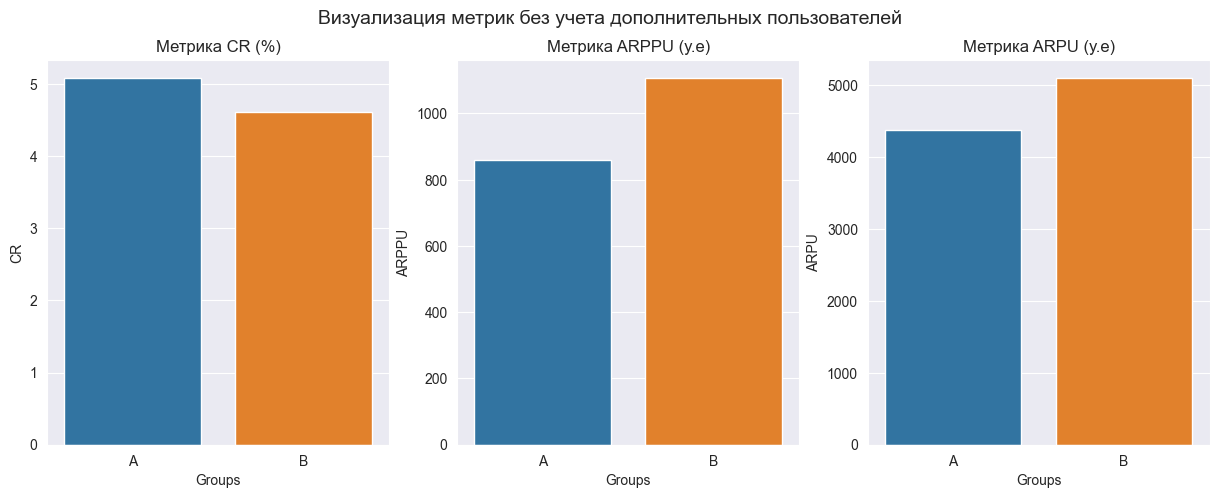

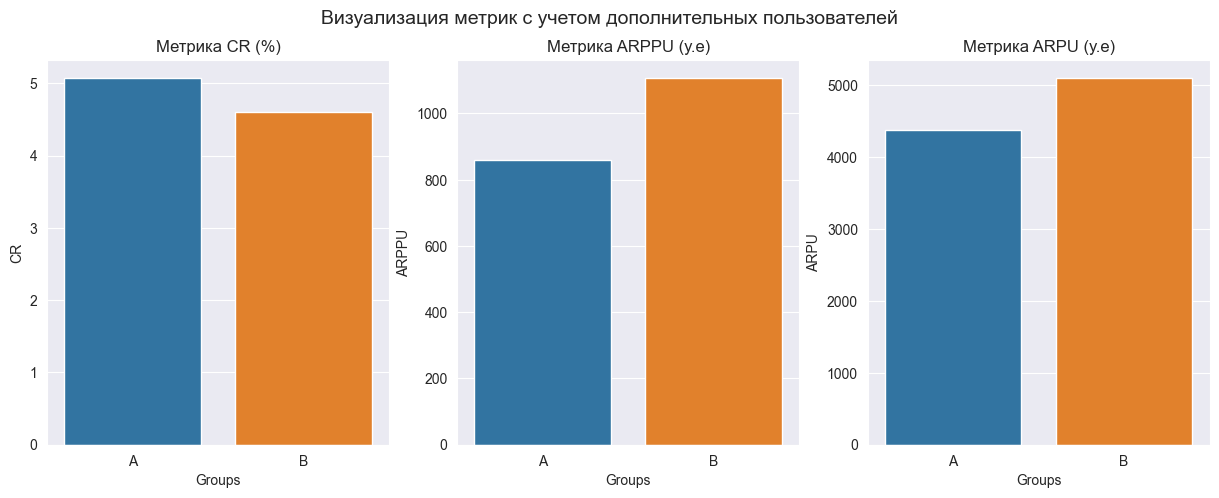

In [76]:
plot_metric(metrics, 'Визуализация метрик без учета дополнительных пользователей')
plot_metric(metrics_nw, 'Визуализация метрик с учетом дополнительных пользователей')

Добавление 92 пользователей к общей выборке из 74,448 человек не оказало значительного влияния на ключевые метрики. Это может быть объяснено тем, что новые пользователи составляют менее 0.13% от общего числа, что недостаточно для значительных изменений в результатах. Поскольку статистически значимые различия сохраняются, можно заключить, что результаты эксперимента остаются устойчивыми, а влияние новой механики оплаты уже адекватно отражено в данных. Однако, есть вероятность, что добавленные пользователи не относятся к целевому сегменту, чувствительному к новой механике, поскольку у них не было новых оплат, что привело к снижению конверсии.

# Заключение:
Новая механика оплаты показала увеличение среднего дохода на платящего пользователя (ARPPU) и среднего дохода на пользователя (ARPU), при этом снижение конверсии не является статистически значимым. Это указывает на то, что новая система оплаты эффективно увеличивает доходы без значимого отрицательного влияния на конверсию. В целом, новая механика демонстрирует положительные результаты и улучшает финансовые показатели.

# Рекомендации:
**Запуск:** Рекомендуется запуск новой механики оплаты, поскольку она положительно влияет на финансовые показатели.

**Обратный тест:** Поскольку при добавлении новых пользователей было замечено снижение конверсии и отсутствие новых оплат, рекомендуется выделить 1% пользователей, для которых будет сохранена старая механика оплаты, и наблюдать за их поведением в течение более продолжительного времени. Это позволит проверить, сохраняются ли различия в ключевых метриках и как долго проявляется эффект новой механики. Если изменения окажутся значительными, это подтвердит, что новая механика влияет на определённые сегменты пользователей.

**Оптимизация:** Полученные данные помогут оптимизировать новую механику оплаты для улучшения пользовательского опыта и достижения лучших результатов.